## DEVICE IMAGE MULTICLASS CLASSIFICATION MODEL ##

#### This pdf/notebook explains the process in involved in training the submitted model with preprocessing and augmentation details. ###


Lets load unzip the data quietly !!! I have attached the drive link to get all the below zip files. We will host the files until Gdrive exixts.

In [0]:
#https://drive.google.com/open?id=1-wZsGQP8mT4X4BlPf6eFuuCo_3l8vRx8
!unzip -qq 'train.zip'
#https://drive.google.com/open?id=102c-Bc3mJyWCuCWpl1mM2td2bU6QgruA
!unzip -qq 'val.zip'
#https://drive.google.com/open?id=102zJLuni35Ep3awDq4AKx9m-5fifyGwf
!unzip -qq 'test.zip'
#https://drive.google.com/open?id=16XrMcy7QWJ_eB347U9PZqhBXxQzxFDND
!unzip -qq 'random.zip'

#https://drive.google.com/open?id=1LvtTKgdBLiYNZzIZh0JH1XswgA_lNsl2
!unzip -qq 'device_D_validate.zip'
#https://drive.google.com/open?id=1RROAVLG5F1ngJI1w18ke-uDaBUNtw-Jr
!unzip -qq 'device_D.zip'
#https://drive.google.com/open?id=1G_B0zGa7LtPa1WETwwHsi8N2ivHS25ND
!unzip -qq 'device_C.zip'
#https://drive.google.com/open?id=1eO6rCcaUD1dWerPe8e6vsJH_zxnpFPbb
!unzip -qq 'device_C_validate.zip'


Loading some important libraries

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import * 
from sklearn.utils import shuffle
#from maskutils import df2imask
import scipy
from shutil import *


In [0]:
#globals 
nclasses=5
size=(384,384,3)
width=size[0]
height=size[1]
depth=size[2]
batch_size=16
seed=1

# path to save our trained model
savepath='model'+'DEVICEv4randocc_384_epoch-{epoch:02d}_acc-{acc:.4f}_val_acc-{val_acc:.4f}_loss-{loss:.4f}_val_loss-{val_loss:.4f}_tp-{tp:.4f}_val_tp-{val_tp:.4f}_tn-{tn:.4f}_val_tn-{val_tn:.4f}_auc_{auc:.4f}_val_auc{val_auc:.4f}.h5'


Our pipeline consists of tf.keras datagenerator to load images to 
our model. It requires images to be stored in class named directory within a main directory. Lets arrange it as follows.

A train dir consisting of separate class folder of images .
Same is done for validation dir.

In [0]:
!mkdir train/device_D
!mkdir val/device_D
!mkdir train/device_C
!mkdir val/device_C

for i in tqdm_notebook(glob('device_C/*')):
  copy(i,'train/device_C/')

for i in tqdm_notebook(glob('device_C_validate/*')):
  copy(i,'val/device_C/')

for i in tqdm_notebook(glob('device_D/*')):
  copy(i,'train/device_D/')

for i in tqdm_notebook(glob('device_D_validate/*')):
  copy(i,'val/device_D/')

for i in tqdm_notebook(glob('random/images/random/*')):
  copy(i,'train/random/')

for i in tqdm_notebook(glob('/content/drive/My Drive/device_classification/trainrandextra/*')):
  copy(i,'train/random/')

for i in tqdm_notebook(glob('/content/drive/My Drive/device_classification/valrandextra/*')):
  copy(i,'val/random/')

Next, we will be loading images to model in count of batch_size to accomodate in our computational resources.

We will use on the fly augmentation such as horizontal flip,vertical flip and random rotation randomly to batches of images.

In [0]:

train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                          rotation_range=90).flow_from_directory(
    "train",
    target_size = (width,height),
    color_mode = 'rgb',
    classes=['random','old','new','device_C','device_D'],
    class_mode='categorical',
    batch_size = batch_size)

val_data_generator = ImageDataGenerator(horizontal_flip=False,vertical_flip=False).flow_from_directory(
    "val",
    target_size = (width,height),
    color_mode = 'rgb',
    classes=['random','old','new','device_C','device_D'],
    class_mode='categorical',
    batch_size = batch_size)


print ('train Indices:',train_data_generator.class_indices)

print ('val Indices:',val_data_generator.class_indices)

#1803
#188

63
Found 1815 images belonging to 5 classes.
Found 194 images belonging to 5 classes.
train Indices: {'random': 0, 'old': 1, 'new': 2, 'device_C': 3, 'device_D': 4}
val Indices: {'random': 0, 'old': 1, 'new': 2, 'device_C': 3, 'device_D': 4}


Time to view what batch of images with augmentation our datgenerators spits out.

In [0]:
dat,lab=next(train_data_generator)
valdat,vallab=next(val_data_generator)

print (dat[0].shape)
for args in range(batch_size):
  #print (dat[args].shape)
  plt.subplots(1,1,sharex='row',figsize=(5,5))
  plt.title(str(lab[args]))
  plt.imshow(np.squeeze(np.array(dat[args],dtype=np.int32)))
plt.show()

print (valdat[0].shape)
for args in range(batch_size):
  #print (dat[args].shape)
  plt.subplots(1,1,sharex='row',figsize=(5,5))
  plt.title(str(vallab[args]))
  plt.imshow(np.squeeze(np.array(valdat[args],dtype=np.int32)))
plt.show()

This is an important step to visualize to distribution of our image arrays. A mismatch distribution between train/val can kill the training as we rely heavily on BatchNorm.

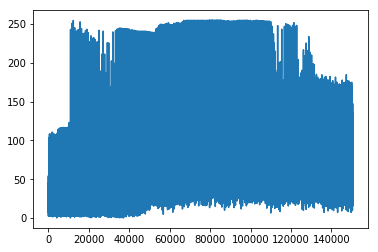

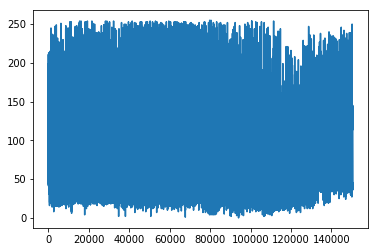

In [0]:
plt.plot(np.ravel(dat[5]))
plt.show()

plt.plot(np.ravel(valdat[5]))
plt.show()

The vital part of training aka loading our model. Our final layer has softmax activation to classify our samples. Explained more in 
preproocessing_and_output.pdf 

In [0]:

K.clear_session()
model=load_model('model/model.h5')
K.eval(model.optimizer.lr)


1e-04

Our actions judge who we are, so as a metric & loss function that judges how good our model is. We keep more weightage on callbacks related AUC metrics to select our best model. Since it's a multi class classification, we stuck to categorical crossentropy 

In [0]:

metrics = [tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.FalsePositives(name='fp'),'accuracy',tf.keras.metrics.AUC(name='auc'),'binary_crossentropy']

optimizer=Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=metrics)

In [0]:
model_checkpoint_acc = ModelCheckpoint(filepath=savepath,
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max',
                                   period=1)
model_checkpoint_loss = ModelCheckpoint(filepath=savepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

model_checkpoint_auc = ModelCheckpoint(filepath=savepath,
                                   monitor='val_auc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max',
                                   period=1)

csv_logger = CSVLogger(filename='devicecf.csv',
                       separator=',',
                       append=True)

callbacks = [model_checkpoint_loss,model_checkpoint_acc,csv_logger,model_checkpoint_auc]

Time for some action. Lets start fitting our sample.......A hundred epochs should be enough to attain train AUC of 1.000 and val_AUC of 0.9999

In [0]:
initial_epoch=0
train_count=1815
val_count=194
#class_weight={0: 1.2660550458715596, 1: 0.8263473053892215}
#callbacks=None
#K.set_value(model.optimizer.lr,7e-5)
print('lr:',K.eval(model.optimizer.lr))
#print ('class weight:',class_weight)
print ('batch_size:',batch_size)
history = model.fit_generator(
      train_data_generator,
      steps_per_epoch=train_count/batch_size,
      validation_data=val_data_generator,
      validation_steps=val_count/batch_size,
      epochs=100,
      verbose=1,initial_epoch=initial_epoch,callbacks=callbacks)

lr: 1e-04
batch_size: 16


After training close to 50 epochs with manually optimising hyperparameters we will reach the SOTA with our model.

TF.KERAS MODEL TO COREML CONVERSION

CoreML does not have direct tf.keras conversion.So we load our keras skeleton from skeleton.h5 and load flesh a.k.a model weights from tf.keras model.h5 . Now we are ready to convert the weight loaded model to coreML

In [0]:
!pip install coremltools
import coremltools

In [0]:
####loading model.h5 tf.keras ####
from tensorflow.keras.models import load_model
base_model=load_model('model/model.h5')
base_model.save_weights('base_weights.h5')
base_model.summary()

In [0]:
import keras
nclasses=5
#download and load keras skeleton here https://drive.google.com/open?id=1b_J3jeXIDIVERywZG84YRXOCPsGmklfS
base_model=load_model('skeleton.h5')
inputs=base_model.inputs
x=base_model.layers[-2].output
x=keras.layers.BatchNormalization()(x)
if nclasses>1:
  act='softmax'
else:
  act='sigmoid'

outputs=keras.layers.Dense(nclasses,activation=act,name='final_'+act)(x)
model=keras.models.Model(inputs,outputs)
print('loading weights....')
print (model.summary())

ml_model=coremltools.converters.keras.convert(model)
ml_model.author = 'fs0c131y'
ml_model.license = 'BSD'
ml_model.short_description = 'Classify 5 scenarios of devices.'
ml_model.save('model.mlmodel')

A simple two line process

TF.KERAS TO ONNX 

In [0]:
!pip3 install onnx
!pip3 install keras2onnx

In [0]:
import keras2onnx
import onnx

model2=load_model('model/model.h5')
print ('model_loaded')
temp=keras2onnx.convert_keras(model2, name='temp1', doc_string='', target_opset=None, channel_first_inputs=None)
onnx.save_model(temp,model.name+'.onnx')

Thank You !!!!!! Flushing all files !!

In [ ]:
!rm -r *